# Repreduction of Cascade 

## Network

The structure of the network is based on VGG. The maxpool is used in each outputlayer with different kernels and strides to keep the 
representation keeps same dimension 512 in this study before entering the MLP layer. The structure is shown below:

In [34]:
%%html
<img src="https://github.com/3505473356/reproduction/blob/main/network.jpg", width=320, heigth=240>

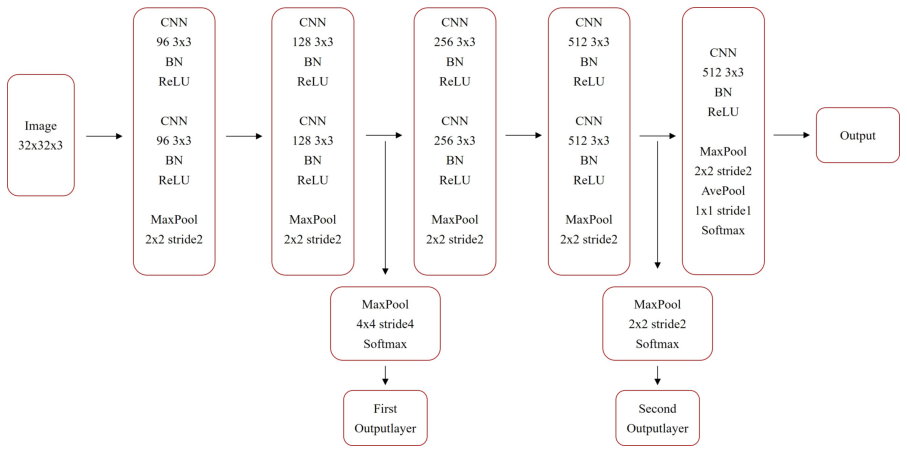

In [30]:
structure = plt.imread("./network.jpg")
plt.figure(figsize=(16,12))
plt.imshow(structure)
plt.axis('off')
plt.show()

## Code

In [6]:
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 
import os
from torchvision.datasets import CIFAR10
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time

In [8]:
# Preparation

## Hyperparameters
### Training and test
train_batch_size = 200
test_batch_size = 200
train_number_epochs = 50

### MLP hidden units
mlp_u = 1024

## Paths, device
NUM_WORKERS = os.cpu_count()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
# print("Number of workers:", NUM_WORKERS)

DATASET_PATH = "../Cascade_2.14/"

## Dataset
input_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_data = CIFAR10(
    root=DATASET_PATH,
    download=True,
    train=True,
    transform=input_transforms,
)

train_dataloader = DataLoader(train_data,
                            shuffle=True,
                            batch_size=train_batch_size)

test_data = CIFAR10(
    root=DATASET_PATH,
    download=True,
    train=False,
    transform=input_transforms,
)

test_dataloader = DataLoader(test_data,
                            shuffle=True,
                            batch_size=test_batch_size)

Device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


In [12]:
# Define the model

class VGG(nn.Module):
    def __init__(self, threshold=None):
        super(VGG, self).__init__()
        
        self.CNN_1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(96, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.CNN_2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.CNN_3 = nn.Sequential(
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.AvgPool2d(kernel_size=1, stride=1)
        )
        
        self.MLP = nn.Sequential(
            nn.Linear(512, mlp_u),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            nn.Linear(mlp_u, mlp_u),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
        )
        
        self.classifier = nn.Linear(mlp_u, 10)
        self.threshold = threshold
        
    def forward(self, x):
        
        if self.threshold == None:
            import time
            start = time.time()
            out1 = self.CNN_1(x)
            out_1 = F.max_pool2d(out1, kernel_size=4, stride=4)
            out_1 = out_1.view(out_1.size(0), -1)
            out_1 = self.MLP(out_1)
            out_1 = self.classifier(out_1)

            torch.cuda.synchronize()
            end_1 = time.time()
            time_1 = (end_1 - start) * 1000  # milliseconds

            out2 = self.CNN_2(out1)
            out_2 = F.max_pool2d(out2, kernel_size=2, stride=2)
            out_2 = out_2.view(out_2.size(0), -1)
            out_2 = self.MLP(out_2)
            out_2 = self.classifier(out_2)

            torch.cuda.synchronize()
            end_2 = time.time()
            time_2 = (end_2 - start) * 1000  # milliseconds

            out3 = self.CNN_3(out2)
            out_3 = out3.view(out3.size(0), -1)
            out_3 = self.MLP(out_3)
            out_3 = self.classifier(out_3)

            torch.cuda.synchronize()
            end_3 = time.time()
            time_3 = (end_3 - start) * 1000  # milliseconds

            return out_1, out_2, out_3, time_1, time_2, time_3
        
        else:
            import time
            start = time.time()
            out1 = self.CNN_1(x)
            out_1 = F.max_pool2d(out1, kernel_size=4, stride=4)
            out_1 = out_1.view(out_1.size(0), -1)
            out_1 = self.MLP(out_1)
            out_1 = self.classifier(out_1)
            out_soft = F.softmax(out_1, dim=1)
            prob, pred = torch.max(out_soft, dim=1)
            
            if prob > self.threshold:
                torch.cuda.synchronize()
                end_1 = time.time()
                time = (end_1 - start) * 1000  # milliseconds
                out = out_1
            
            else:
                out2 = self.CNN_2(out1)
                out_2 = F.max_pool2d(out2, kernel_size=2, stride=2)
                out_2 = out_2.view(out_2.size(0), -1)
                out_2 = self.MLP(out_2)
                out_2 = self.classifier(out_2)
                out_soft = F.softmax(out_1, dim=1)
                prob, pred = torch.max(out_soft, dim=1)
                
                if prob > self.threshold:
                    torch.cuda.synchronize()
                    end_2 = time.time()
                    time = (end_2 - start) * 1000  # milliseconds
                    out = out_2
                
                else:
                    out3 = self.CNN_3(out2)
                    out_3 = out3.view(out3.size(0), -1)
                    out_3 = self.MLP(out_3)
                    out_3 = self.classifier(out_3)
                    
                    torch.cuda.synchronize()
                    end_3 = time.time()
                    time = (end_3 - start) * 1000  # milliseconds
                    out = out_3
            return out, time

In [10]:
# Define test function

## Test function during training
def test(epoch):
    model.eval()
    correct1 = 0
    correct2 = 0
    correct3 = 0
    times_1 = []
    times_2 = []
    times_3 = []
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            out1, out2, out3, time_1, time_2, time_3 = model(images)
            out1, out2, out3 = out1.cpu(), out2.cpu(), out3.cpu()
            out_1, out_2, out_3 = out1.numpy(), out2.numpy(), out3.numpy()
            _, predicted1 = torch.max(out1, 1)
            _, predicted2 = torch.max(out2, 1)
            _, predicted3 = torch.max(out3, 1)
            
            total += labels.size(0)
            
            correct1 += (predicted1 == labels).sum()
            correct2 += (predicted2 == labels).sum()
            correct3 += (predicted3 == labels).sum()
            
            times_1.append(time_1)
            times_2.append(time_2)
            times_3.append(time_3)
            
    accuracy1 = 100 * correct1 / total
    accuracy_rate1.append(accuracy1)
    
    accuracy2 = 100 * correct2 / total
    accuracy_rate2.append(accuracy2)
    
    accuracy3 = 100 * correct3 / total
    accuracy_rate3.append(accuracy3)
    
    time_array_1.append(np.mean(time_1))
    time_array_2.append(np.mean(time_2))
    time_array_3.append(np.mean(time_3))
    
    print(f" {epoch} epoch, test_accuracy1={accuracy1}, test_accuracy2={accuracy2}, test_accuracy2={accuracy3}")
    print(f" {epoch} epoch, running_time1={np.mean(time_1)}, running_time2={np.mean(time_2)}, running_time3={np.mean(time_3)}")

## Test function during online processing
def test_threshold(threshold):
    
    test_dataloader = DataLoader(test_data,shuffle=True,batch_size=1)
    model = VGG(threshold)
    model.load_state_dict(torch.load("./Cascade.pth"))
    model.eval()
    model.to(device)
    correct = 0
    correct1 = 0
    correct2 = 0
    correct3 = 0
    times = []
    accuracy_rate = []
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            out, time = model(images)
            out = out.cpu()
            out_np = out.numpy()
            
            prob1, predicted1 = torch.max(out, 1)
            total += labels.size(0)
            correct += (predicted1 == labels).sum()
            
            times.append(time)
            
    accuracy = 100 * correct / total
    
    print("Correct prediction", correct)
    print("Test dataset size", total)
    print(f" threshold: {threshold}, accuracy: {accuracy}, mean running time for 1 sample: {np.mean(times)}")

### Training

In [ ]:
# Training block

model = VGG()
# model.load_state_dict(torch.load('CIFAR-model/VGG16.pth'))
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-3)
loss_func = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4, last_epoch=-1)

epochs = 100
accuracy_rate1 = []
accuracy_rate2 = []
accuracy_rate3 = []

time_array_1 = []
time_array_2 = []
time_array_3 = []

loss_array1 = []
loss_array2 = []
loss_array3 = []
loss_array = []
    
for epoch in range(epochs):
    model.train()
    model.to(device)
    running_loss = 0.0
    running_loss1 = 0.0
    running_loss2 = 0.0
    running_loss3 = 0.0
    total_correct = 0
    total_trainset = 0
 
    for i, (data, labels) in enumerate(train_dataloader, start=0):
        data = data.to(device)
        out_1, out_2, out_3, _, _, _ = model(data)
        
        labels = labels.to(device)
        
        loss1 = loss_func(out_1, labels).to(device)
        loss2 = loss_func(out_2, labels).to(device)
        loss3 = loss_func(out_3, labels).to(device)
        loss = torch.mean(loss1+loss2+loss3)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_loss1 += loss1.item()
        running_loss2 += loss2.item()
        running_loss3 += loss3.item()
        _, pred = out_3.max(1)
        correct = (pred == labels).sum().item()
        total_correct += correct
        total_trainset += data.shape[0]
        if i % 100 == 0 and i > 0:
            loss_array1.append(running_loss1)
            loss_array2.append(running_loss2)
            loss_array3.append(running_loss3)
            loss_array.append(running_loss)
            
            running_loss = 0.0
            running_loss1 = 0.0
            running_loss2 = 0.0
            running_loss3 = 0.0
    test(epoch)
#     print(f" {i} episode, loss={running_loss}, loss_firstlayer={running_loss1}, loss_secondlayer={running_loss2}, loss_full={running_loss3}")            
    scheduler.step()
    
torch.save(model.state_dict(), './Cascade_new.pth')

### Result

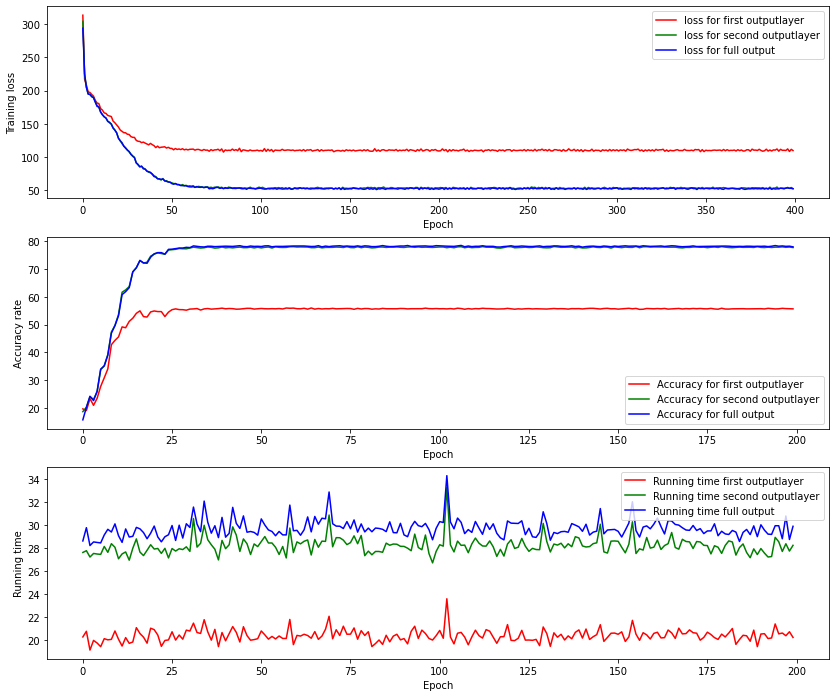

In [12]:
plt.figure(figsize=(14,12))

plt.subplot(3, 1, 1)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.plot(loss_array1, 'r', label="loss for first outputlayer")
plt.plot(loss_array2, 'g', label="loss for second outputlayer")
plt.plot(loss_array3, 'b', label="loss for full output")
# plt.plot(loss_array1, 'ro')
# plt.plot(loss_array2, 'go')
# plt.plot(loss_array3, 'bo')
plt.legend()

plt.subplot(3, 1, 2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy rate')

plt.plot(accuracy_rate1, 'r', label="Accuracy for first outputlayer")
plt.plot(accuracy_rate2, 'g', label="Accuracy for second outputlayer")
plt.plot(accuracy_rate3, 'b', label="Accuracy for full output")
# plt.plot(accuracy_rate1, 'ro')
# plt.plot(accuracy_rate2, 'go')
# plt.plot(accuracy_rate3, 'bo')
plt.legend()

plt.subplot(3, 1, 3)
plt.xlabel('Epoch')
plt.ylabel('Running time')

plt.plot(time_array_1, 'r', label="Running time first outputlayer")
plt.plot(time_array_2, 'g', label="Running time second outputlayer")
plt.plot(time_array_3, 'b', label="Running time full output")

# plt.plot(time_array_1, 'ro')
# plt.plot(time_array_2, 'go')
# plt.plot(time_array_3, 'bo')

plt.legend()
plt.show()

According to the images showing the training loss and test accuracy, the performance in the second outputlayer and the whole network is similar, with a training loss of around `26` and test accuracy of around `77%`, as, in this study, the final part of the network is shallow and do not bring significant improvement. The performance of the first output layer stays at the training loss of `53.7` and test accuracy `57%`, which demonstrates that the first outputlayer has the ability to deal with the most of the samples, which are easy in a fewer processing time around `21` ms, around `70` percent of the processing time around `27`ms and `29`ms in the second layer and entire network.

The best performance of the entire network stays at `78%`, which is lower than `85%` without training the little network. It is probably affected by the ability limitation of the little network and could be improved with a better training process.

In [77]:
test_threshold(0.5)
print("*********************")
test_threshold(0.8)
print("*********************")
test_threshold(0.96)

Correct prediction tensor(6868)
Test dataset size 10000
 threshold: 0.5, accuracy: 68.68000030517578, mean running time for 1 sample: 1.4344523906707765
*********************
Correct prediction tensor(7542)
Test dataset size 10000
 threshold: 0.8, accuracy: 75.41999816894531, mean running time for 1 sample: 1.8826518535614014
*********************
Correct prediction tensor(7806)
Test dataset size 10000
 threshold: 0.96, accuracy: 78.05999755859375, mean running time for 1 sample: 2.1369862079620363


With setting the threshold for the confidence of the output, the network will have the stop mechanism. When setting the low threshold, the first output layer has already meets the requirement and stop there with short processing time. With increasing the threshold, it beyonds the first output layer' ability and the depth network is activated to the processing. 

### Limitation

1. The network is not scalable. The network structure is designed sepecifically for the 32x32x3 input, it can be further improved with a better network structure.

2. The image processing with threshold is only designed for 1 batch size. It is only designed for one image once, when real deployment with multi-robots, the batch process should be considered.

3. Introduce some tricks in representation learning. Self-supervised learning and transformer-structured network is popular, and some tricks like projection MLP can be introduced to try to improve the quality of the representation and the performance in the shallow little network.